# Evaluate the Neighborhood at New York City

## Introduction: Business Problem

The capstone project aims at finding the best neighborhood to live in the city of New York if you like Chinese food. <br> <br> 
New York City itself contains by far the highest ethnic Chinese population of any individual city outside Asia, estimated at 628,763 as of 2017. <a href="https://en.wikipedia.org/wiki/Chinese_people_in_New_York_City">[wiki]</a>  Among the earliest documented arrivals of Chinese immigrants in New York City were of "sailors and peddlers" in the 1830s. Many more Chinese immigrants arrived and settled in Lower Manhattan throughout the 1800s. Large-scale immigration continues from China after 2013. <br><br> 
As many immigrant Chinese to New York City move up the socioeconomic ladder, many have relocated to the suburbs for more living space as well as seeking particular school districts for their children. In this process, new Chinese enclaves and Chinatown commercial districts have emerged and are growing in these suburbs. The need to find the best neighborhood to live with prefered Chinese cuisine is on the rise. <br> <br> 
This report explores which neighborhoods and boroughs of New York City have the most as well as the best Chinese restaurants based on current Four Square data. 
The target client for this project is the ones who are trying to explores which neighborhoods of New York City have the best Chinese restaurants.

## Data

In order to answer the above questions, following datas are needed:

1. New York City data containing the neighborhoods and boroughs, latitudes, and longitudes will be obtained from the data source: https://cocl.us/new_york_dataset

2. New York City data containing neighborhood boundaries will be obtained from the data source: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm

3. All data related to locations and quality of Chinese restaurants will be obtained via the FourSquare API utilized via the Request library in Python.

## Methodology


First, New York City data will be collected and wrangler. from https://cocl.us/new_york_dataset and cleaned and processed into a dataframe.

Second, combining with FourSquare database, the data will be filtered by ratings, tips, for each neighborhood.

Finally, the data be will be visually assessed using graphing from various Python libraries.

In [5]:
## Problem Statementimport pandas as pd
import numpy as np
import requests
#from bs4 import BeautifulSoup
import os
!conda install -c conda-forge folium=0.5.0 --yes
import folium 
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns

print('Done!')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Done!


In [12]:
import json # library to handle JSON files

In [13]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [6]:
import pandas as pd

In [14]:
neighborhoods_data = newyork_data['features']
neighborhoods_data[0]
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [13]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [18]:
CLIENT_ID = 'OCEE3CXQPZCNUFI3DQX4QXODBDRNAO2IS3AWZNNXFIHT2EW1' # your Foursquare ID
CLIENT_SECRET = 'MFFMM0EW0F041S3NJ4EEFKXVZP0A02ONOPESCQTZ0YVKFDMP' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: OCEE3CXQPZCNUFI3DQX4QXODBDRNAO2IS3AWZNNXFIHT2EW1
CLIENT_SECRET:MFFMM0EW0F041S3NJ4EEFKXVZP0A02ONOPESCQTZ0YVKFDMP


In [36]:
CLIENT_ID = 'KT1VN0IMTFO0B3X2R0AACAJGRSMLXNO5BWHSBSPROZOI20SK' # your Foursquare ID
CLIENT_SECRET = 'BQ0P52FZIBKP0TZOJGSQZ1TGS33N00BVQT21IQLPMP53X2QB' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: KT1VN0IMTFO0B3X2R0AACAJGRSMLXNO5BWHSBSPROZOI20SK
CLIENT_SECRET:BQ0P52FZIBKP0TZOJGSQZ1TGS33N00BVQT21IQLPMP53X2QB


In [9]:
# Functions

def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [15]:
ny_data = neighborhoods
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


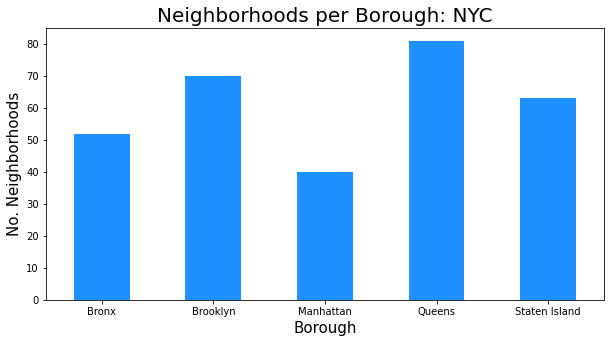

In [16]:
clr = "dodgerblue"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [19]:
# queens has most neighborhoods
# prepare neighborhood list that contains chinese resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
chinese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    chinese_resturants=venues[venues['Category']=='Chinese Restaurant']   
    print('(',count,'/',len(ny_data),')','Chinese Resturants in '+Neighborhood+', '+Borough+':'+str(len(chinese_resturants)))
    print(row)
    for resturant_detail in chinese_resturants.values.tolist():
        id, name , category=resturant_detail
        chinese_rest_ny = chinese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Chinese Resturants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Chinese Resturants in Co-op City, Bronx:1
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Chinese Resturants in Eastchester, Bronx:1
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Chinese Resturants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Chinese Resturants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Chinese Resturants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Chinese Resturants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Chinese Resturants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Chinese Resturants in Norwood, Bronx:0
['Bronx', '

( 68 / 306 ) Chinese Resturants in Red Hook, Brooklyn:0
['Brooklyn', 'Red Hook', 40.676253230250886, -74.0127589747356]
( 69 / 306 ) Chinese Resturants in Gowanus, Brooklyn:1
['Brooklyn', 'Gowanus', 40.673931143187154, -73.99444087145339]
( 70 / 306 ) Chinese Resturants in Fort Greene, Brooklyn:0
['Brooklyn', 'Fort Greene', 40.68852726018977, -73.97290574369092]
( 71 / 306 ) Chinese Resturants in Park Slope, Brooklyn:1
['Brooklyn', 'Park Slope', 40.67232052268197, -73.97705030183924]
( 72 / 306 ) Chinese Resturants in Cypress Hills, Brooklyn:1
['Brooklyn', 'Cypress Hills', 40.68239101144211, -73.87661596457296]
( 73 / 306 ) Chinese Resturants in East New York, Brooklyn:2
['Brooklyn', 'East New York', 40.669925700847045, -73.88069863917366]
( 74 / 306 ) Chinese Resturants in Starrett City, Brooklyn:0
['Brooklyn', 'Starrett City', 40.64758905230874, -73.87936970045875]
( 75 / 306 ) Chinese Resturants in Canarsie, Brooklyn:0
['Brooklyn', 'Canarsie', 40.63556432797428, -73.90209269778966]


( 132 / 306 ) Chinese Resturants in Jackson Heights, Queens:0
['Queens', 'Jackson Heights', 40.75198138007367, -73.88282109164365]
( 133 / 306 ) Chinese Resturants in Elmhurst, Queens:2
['Queens', 'Elmhurst', 40.744048505122024, -73.88165622288388]
( 134 / 306 ) Chinese Resturants in Howard Beach, Queens:1
['Queens', 'Howard Beach', 40.65422527738487, -73.8381376460028]
( 135 / 306 ) Chinese Resturants in Corona, Queens:1
['Queens', 'Corona', 40.74238175015667, -73.85682497345258]
( 136 / 306 ) Chinese Resturants in Forest Hills, Queens:1
['Queens', 'Forest Hills', 40.72526378216503, -73.84447500788983]
( 137 / 306 ) Chinese Resturants in Kew Gardens, Queens:2
['Queens', 'Kew Gardens', 40.7051790354148, -73.82981905825703]
( 138 / 306 ) Chinese Resturants in Richmond Hill, Queens:0
['Queens', 'Richmond Hill', 40.69794731471763, -73.83183321446887]
( 139 / 306 ) Chinese Resturants in Flushing, Queens:1
['Queens', 'Flushing', 40.76445419697846, -73.83177300329582]
( 140 / 306 ) Chinese R

( 199 / 306 ) Chinese Resturants in New Brighton, Staten Island:0
['Staten Island', 'New Brighton', 40.64061455913511, -74.08701650516625]
( 200 / 306 ) Chinese Resturants in Stapleton, Staten Island:1
['Staten Island', 'Stapleton', 40.62692762538176, -74.07790192660066]
( 201 / 306 ) Chinese Resturants in Rosebank, Staten Island:0
['Staten Island', 'Rosebank', 40.61530494652761, -74.06980526716141]
( 202 / 306 ) Chinese Resturants in West Brighton, Staten Island:0
['Staten Island', 'West Brighton', 40.63187892654607, -74.1071817826561]
( 203 / 306 ) Chinese Resturants in Grymes Hill, Staten Island:0
['Staten Island', 'Grymes Hill', 40.624184791313006, -74.08724819983729]
( 204 / 306 ) Chinese Resturants in Todt Hill, Staten Island:0
['Staten Island', 'Todt Hill', 40.59706851814673, -74.1113288180088]
( 205 / 306 ) Chinese Resturants in South Beach, Staten Island:0
['Staten Island', 'South Beach', 40.58024741350956, -74.0795529253982]
( 206 / 306 ) Chinese Resturants in Port Richmond, 

( 260 / 306 ) Chinese Resturants in Remsen Village, Brooklyn:0
['Brooklyn', 'Remsen Village', 40.652117451793494, -73.91665331978048]
( 261 / 306 ) Chinese Resturants in New Lots, Brooklyn:2
['Brooklyn', 'New Lots', 40.6627442796966, -73.88511776379292]
( 262 / 306 ) Chinese Resturants in Paerdegat Basin, Brooklyn:0
['Brooklyn', 'Paerdegat Basin', 40.63131755039667, -73.90233474295836]
( 263 / 306 ) Chinese Resturants in Mill Basin, Brooklyn:2
['Brooklyn', 'Mill Basin', 40.61597423962336, -73.91515391550404]
( 264 / 306 ) Chinese Resturants in Jamaica Hills, Queens:1
['Queens', 'Jamaica Hills', 40.71145964370482, -73.79646462081593]
( 265 / 306 ) Chinese Resturants in Utopia, Queens:0
['Queens', 'Utopia', 40.73350025429757, -73.79671678028349]
( 266 / 306 ) Chinese Resturants in Pomonok, Queens:0
['Queens', 'Pomonok', 40.73493618075478, -73.80486120040537]
( 267 / 306 ) Chinese Resturants in Astoria Heights, Queens:0
['Queens', 'Astoria Heights', 40.7703173929982, -73.89467996270574]
(

In [3]:
chinese_rest_ny.to_csv('chinese_rest_ny_tocsv1.csv') # Save the information so far to a .csv file due to limited calls on FourSquare

NameError: name 'chinese_rest_ny' is not defined

In [17]:
chinese_rest_ny = pd.read_csv('chinese_rest_ny_tocsv1.csv')
chinese_rest_ny=chinese_rest_ny.iloc[:,3:8]
chinese_rest_ny.tail()

,Borough,Neighborhood,ID,Name
161,Brooklyn,Homecrest,4d28b924ebacb1f72efbf34f,Wing Hing Seafood Restaurant
162,Brooklyn,Homecrest,514645bae4b0238f38bcdbac,Season Restaurant
163,Brooklyn,Homecrest,4c54639f72cf0f47cd247bd4,Winley
164,Bronx,Kingsbridge Heights,4d965fd061a3a1cde4989a42,Lucky Star Chinese Restaurant
165,Brooklyn,Erasmus,4e10c87122713f7d7bcb9d1d,Kam Man Chinese Food


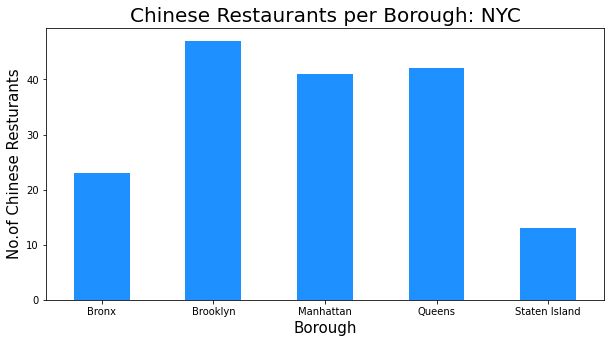

In [18]:
chinese_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color = clr)
plt.title('Chinese Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Chinese Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

### Brooklyn has the most Chinese Resturants in NYC

In [37]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
chinese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in chinese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
       # print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(chinese_rest_ny),')','processed')
    chinese_rest_stats_ny = chinese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
chinese_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '5ff332cd1fbc1169c9001baf'}, 'response': {'venue': {'id': '4c9d5f2654c8a1cd2e71834b', 'name': 'Guang Hui Chinese Restaurant', 'contact': {'phone': '7188623288', 'formattedPhone': '(718) 862-3288'}, 'location': {'address': '125 Dreiser Loop', 'lat': 40.876651, 'lng': -73.829092, 'labeledLatLngs': [{'label': 'display', 'lat': 40.876651, 'lng': -73.829092}, {'label': 'entrance', 'lat': 40.876084, 'lng': -73.829209}], 'postalCode': '10475', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['125 Dreiser Loop', 'Bronx, NY 10475', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/guang-hui-chinese-restaurant/4c9d5f2654c8a1cd2e71834b', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'st

{'meta': {'code': 200, 'requestId': '5ff332cda00d400630ab1c01'}, 'response': {'venue': {'id': '4b9d6b45f964a52078ab36e3', 'name': "Mr. Q's Chinese Restaurant", 'contact': {'phone': '7188232424', 'formattedPhone': '(718) 823-2424'}, 'location': {'address': '2115 Williamsbridge Rd', 'lat': 40.85579022389548, 'lng': -73.8554550059393, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85579022389548, 'lng': -73.8554550059393}, {'label': 'entrance', 'lat': 40.855784, 'lng': -73.855745}], 'postalCode': '10461', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2115 Williamsbridge Rd', 'Bronx, NY 10461', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/mr-qs-chinese-restaurant/4b9d6b45f964a52078ab36e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'prim

{'meta': {'code': 200, 'requestId': '5ff332ce84b9f728bebdce74'}, 'response': {'venue': {'id': '4cba4a550180721ebb739961', 'name': 'Rose Flower Chinese', 'contact': {'phone': '7183643542', 'formattedPhone': '(718) 364-3542'}, 'location': {'address': '383 Bedford Park Blvd', 'crossStreet': 'decatur avenue', 'lat': 40.867958, 'lng': -73.88385799999999, 'labeledLatLngs': [{'label': 'display', 'lat': 40.867958, 'lng': -73.88385799999999}, {'label': 'entrance', 'lat': 40.867904, 'lng': -73.883944}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['383 Bedford Park Blvd (decatur avenue)', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/rose-flower-chinese/4cba4a550180721ebb739961', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 's

{'meta': {'code': 200, 'requestId': '5ff332cf54a4277f8f83f52e'}, 'response': {'venue': {'id': '4d2d1728762fa143051f7664', 'name': 'Dong King', 'contact': {}, 'location': {'address': '80 W 165th St', 'lat': 40.833692, 'lng': -73.92746600000001, 'labeledLatLngs': [{'label': 'display', 'lat': 40.833692, 'lng': -73.92746600000001}, {'label': 'entrance', 'lat': 40.833888, 'lng': -73.927236}], 'postalCode': '10452', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['80 W 165th St', 'Bronx, NY 10452', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dong-king/4d2d1728762fa143051f7664', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'li

{'meta': {'code': 200, 'requestId': '5ff332d07154b86bdc6b8109'}, 'response': {'venue': {'id': '4e656e8252b1260c14683b4b', 'name': 'Kee Hing Restaurant', 'contact': {'phone': '7189911105', 'formattedPhone': '(718) 991-1105'}, 'location': {'address': '845 Soundview Ave', 'crossStreet': 'Story Ave.', 'lat': 40.822140999999995, 'lng': -73.8677, 'labeledLatLngs': [{'label': 'display', 'lat': 40.822140999999995, 'lng': -73.8677}, {'label': 'entrance', 'lat': 40.822374, 'lng': -73.867704}], 'postalCode': '10473', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['845 Soundview Ave (Story Ave.)', 'Bronx, NY 10473', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kee-hing-restaurant/4e656e8252b1260c14683b4b', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, '

{'meta': {'code': 200, 'requestId': '5ff332d1db73076d0e8a44cc'}, 'response': {'venue': {'id': '4c7d29b2d598a09354f6c162', 'name': 'Happy Garden', 'contact': {'phone': '7184091471', 'formattedPhone': '(718) 409-1471'}, 'location': {'address': '706 Morris Park Ave', 'crossStreet': 'White plains rd', 'lat': 40.84506, 'lng': -73.865557, 'labeledLatLngs': [{'label': 'display', 'lat': 40.84506, 'lng': -73.865557}, {'label': 'entrance', 'lat': 40.845184, 'lng': -73.865597}], 'postalCode': '10462', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['706 Morris Park Ave (White plains rd)', 'Bronx, NY 10462', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/happy-garden/4c7d29b2d598a09354f6c162', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}]

{'meta': {'code': 200, 'requestId': '5ff332d2119a9f2907091b88'}, 'response': {'venue': {'id': '4b5f3d97f964a52074af29e3', 'name': 'Lee Xing', 'contact': {'phone': '7188297945', 'formattedPhone': '(718) 829-7945'}, 'location': {'address': '3207 Westchester Ave', 'lat': 40.851829528808594, 'lng': -73.82991027832031, 'labeledLatLngs': [{'label': 'display', 'lat': 40.851829528808594, 'lng': -73.82991027832031}], 'postalCode': '10461', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3207 Westchester Ave', 'Bronx, NY 10461', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lee-xing/4b5f3d97f964a52074af29e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tier': 1, 'message': 'Ch

{'meta': {'code': 200, 'requestId': '5ff332d369128074fbc43217'}, 'response': {'venue': {'id': '4d9a695ee5fd6ea8e3096df5', 'name': 'Lucky House Chinese Restaurant', 'contact': {'phone': '7186817430', 'formattedPhone': '(718) 681-7430'}, 'location': {'address': '202 E 167th St', 'lat': 40.83393302779995, 'lng': -73.91667401417777, 'labeledLatLngs': [{'label': 'display', 'lat': 40.83393302779995, 'lng': -73.91667401417777}, {'label': 'entrance', 'lat': 40.833882, 'lng': -73.916574}], 'postalCode': '10456', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['202 E 167th St', 'Bronx, NY 10456', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lucky-house-chinese-restaurant/4d9a695ee5fd6ea8e3096df5', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary'

{'meta': {'code': 200, 'requestId': '5ff332d31194107fdc8b787d'}, 'response': {'venue': {'id': '4d9dead0c4b537041abc212e', 'name': 'Tong Xing Chinese & New Taco Mexican Food', 'contact': {'phone': '7183312227', 'formattedPhone': '(718) 331-2227'}, 'location': {'address': '7524 18th Ave', 'crossStreet': '76th st', 'lat': 40.61280502681869, 'lng': -73.99657266546886, 'labeledLatLngs': [{'label': 'display', 'lat': 40.61280502681869, 'lng': -73.99657266546886}], 'postalCode': '11214', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['7524 18th Ave (76th st)', 'Brooklyn, NY 11214', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tong-xing-chinese--new-taco-mexican-food/4d9dead0c4b537041abc212e', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary

{'meta': {'code': 200, 'requestId': '5ff332d4e040152d9ba1ea41'}, 'response': {'venue': {'id': '4abd867df964a520d78a20e3', 'name': 'Shang Hai Lee', 'contact': {'phone': '7183496716', 'formattedPhone': '(718) 349-6716'}, 'location': {'address': '157 Franklin St', 'crossStreet': 'India & Java', 'lat': 40.731829236676546, 'lng': -73.95784627979856, 'labeledLatLngs': [{'label': 'display', 'lat': 40.731829236676546, 'lng': -73.95784627979856}], 'postalCode': '11222', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['157 Franklin St (India & Java)', 'Brooklyn, NY 11222', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/shang-hai-lee/4abd867df964a520d78a20e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': 

{'meta': {'code': 200, 'requestId': '5ff332d4a123683dcbbebac0'}, 'response': {'venue': {'id': '4ce992278ef78cfa2eb6a19b', 'name': 'New Li Hing', 'contact': {'phone': '7183739708', 'formattedPhone': '(718) 373-9708'}, 'location': {'address': '304 Avenue U', 'crossStreet': 'b/w McDonald Ave and West St', 'lat': 40.596874, 'lng': -73.972654, 'labeledLatLngs': [{'label': 'display', 'lat': 40.596874, 'lng': -73.972654}, {'label': 'entrance', 'lat': 40.596926, 'lng': -73.97268}], 'postalCode': '11223', 'cc': 'US', 'neighborhood': 'Gravesend', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['304 Avenue U (b/w McDonald Ave and West St)', 'Brooklyn, NY 11223', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/new-li-hing/4ce992278ef78cfa2eb6a19b', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food

{'meta': {'code': 200, 'requestId': '5ff332d5ac600140108aa268'}, 'response': {'venue': {'id': '54e39b14498e9c646b42958e', 'name': 'East Wind Snack Shop', 'contact': {'phone': '9292950188', 'formattedPhone': '(929) 295-0188'}, 'location': {'address': '471 16th St', 'crossStreet': 'at Prospect Park West', 'lat': 40.660297, 'lng': -73.980169, 'labeledLatLngs': [{'label': 'display', 'lat': 40.660297, 'lng': -73.980169}], 'postalCode': '11215', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['471 16th St (at Prospect Park West)', 'Brooklyn, NY 11215', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/east-wind-snack-shop/54e39b14498e9c646b42958e', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount

{'meta': {'code': 200, 'requestId': '5ff332d5b5ab190c7170b03f'}, 'response': {'venue': {'id': '4c06e2470e0a2d7fdf8aec0c', 'name': '#1 Garden Chinese Food', 'contact': {'phone': '7188321795', 'formattedPhone': '(718) 832-1795'}, 'location': {'address': '221 Prospect Park W', 'lat': 40.660248811093595, 'lng': -73.98054235147856, 'labeledLatLngs': [{'label': 'display', 'lat': 40.660248811093595, 'lng': -73.98054235147856}, {'label': 'entrance', 'lat': 40.660106, 'lng': -73.980445}], 'postalCode': '11215', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['221 Prospect Park W', 'Brooklyn, NY 11215', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/1-garden-chinese-food/4c06e2470e0a2d7fdf8aec0c', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary

{'meta': {'code': 200, 'requestId': '5ff332d62b881e51cd7c79bc'}, 'response': {'venue': {'id': '4a9ac078f964a5207c3220e3', 'name': 'Fortune House', 'contact': {'phone': '7188557055', 'formattedPhone': '(718) 855-7055'}, 'location': {'address': '82 Henry St', 'crossStreet': 'btwn Pineapple & Orange St', 'lat': 40.698411434008214, 'lng': -73.99254201285272, 'labeledLatLngs': [{'label': 'display', 'lat': 40.698411434008214, 'lng': -73.99254201285272}, {'label': 'entrance', 'lat': 40.69842, 'lng': -73.992688}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['82 Henry St (btwn Pineapple & Orange St)', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/fortune-house/4a9ac078f964a5207c3220e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/f

{'meta': {'code': 200, 'requestId': '5ff332d681c8ff11f106853d'}, 'response': {'venue': {'id': '4a986a9cf964a520e82b20e3', 'name': 'Great Wall Chinese Food', 'contact': {'phone': '7188552630', 'formattedPhone': '(718) 855-2630'}, 'location': {'address': '60 Henry St', 'crossStreet': 'btw Cranberry St and Orange St', 'lat': 40.698983696296274, 'lng': -73.99218529980111, 'labeledLatLngs': [{'label': 'display', 'lat': 40.698983696296274, 'lng': -73.99218529980111}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['60 Henry St (btw Cranberry St and Orange St)', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/great-wall-chinese-food/4a986a9cf964a520e82b20e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'},

{'meta': {'code': 200, 'requestId': '5ff332d7db73076d0e8a5852'}, 'response': {'venue': {'id': '4b09dc38f964a520cf1e23e3', 'name': 'Ting Hua', 'contact': {'phone': '7188526287', 'formattedPhone': '(718) 852-6287'}, 'location': {'address': '351 Smith St', 'crossStreet': 'at Carroll St.', 'lat': 40.6799366374633, 'lng': -73.99512985321104, 'labeledLatLngs': [{'label': 'display', 'lat': 40.6799366374633, 'lng': -73.99512985321104}, {'label': 'entrance', 'lat': 40.679872, 'lng': -73.994989}], 'postalCode': '11231', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['351 Smith St (at Carroll St.)', 'Brooklyn, NY 11231', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ting-hua/4b09dc38f964a520cf1e23e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'pr

{'meta': {'code': 200, 'requestId': '5ff332d85009f56728195086'}, 'response': {'venue': {'id': '49bb541ff964a520e3531fe3', 'name': 'Hunan Delight', 'contact': {'phone': '7187891400', 'formattedPhone': '(718) 789-1400'}, 'location': {'address': '752 Union St', 'crossStreet': 'b/t 5th and 6th ave', 'lat': 40.67546106658002, 'lng': -73.97804145177376, 'labeledLatLngs': [{'label': 'display', 'lat': 40.67546106658002, 'lng': -73.97804145177376}, {'label': 'entrance', 'lat': 40.675398, 'lng': -73.978171}], 'postalCode': '11215', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['752 Union St (b/t 5th and 6th ave)', 'Brooklyn, NY 11215', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hunan-delight/49bb541ff964a520e3531fe3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 

{'meta': {'code': 200, 'requestId': '5ff332d82742ec17727707ee'}, 'response': {'venue': {'id': '4f326c1a19836c91c7d64648', 'name': 'Wo Hop Chinese Restaurant', 'contact': {'phone': '7182357955', 'formattedPhone': '(718) 235-7955'}, 'location': {'address': '3150 Fulton St', 'lat': 40.681668, 'lng': -73.878741, 'labeledLatLngs': [{'label': 'display', 'lat': 40.681668, 'lng': -73.878741}, {'label': 'entrance', 'lat': 40.681716, 'lng': -73.878621}], 'postalCode': '11208', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3150 Fulton St', 'Brooklyn, NY 11208', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/wo-hop-chinese-restaurant/4f326c1a19836c91c7d64648', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats'

{'meta': {'code': 200, 'requestId': '5ff332d9ce97eb2c215eb9b3'}, 'response': {'venue': {'id': '4c5075d73940be9ae2124a07', 'name': 'new grand wok', 'contact': {'phone': '7186451993', 'formattedPhone': '(718) 645-1993'}, 'location': {'address': '3510 Avenue S', 'lat': 40.609311, 'lng': -73.931668, 'labeledLatLngs': [{'label': 'display', 'lat': 40.609311, 'lng': -73.931668}, {'label': 'entrance', 'lat': 40.609357, 'lng': -73.931719}], 'postalCode': '11234', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3510 Avenue S', 'Brooklyn, NY 11234', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/new-grand-wok/4c5075d73940be9ae2124a07', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price'

{'meta': {'code': 200, 'requestId': '5ff332da9b7ed63fe396c795'}, 'response': {'venue': {'id': '59da9590e1f0aa52976b8f35', 'name': 'Han Dynasty', 'contact': {}, 'location': {'address': '445 Albee Sq', 'crossStreet': 'Fleet St', 'lat': 40.691333919005594, 'lng': -73.98245632424464, 'labeledLatLngs': [{'label': 'display', 'lat': 40.691333919005594, 'lng': -73.98245632424464}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['445 Albee Sq (Fleet St)', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/han-dynasty/59da9590e1f0aa52976b8f35', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d142941735', 'name': 'Asian Restaurant', 'pluralName': 'Asian Restaurants', 'short

{'meta': {'code': 200, 'requestId': '5ff332dace97eb2c215ebe1b'}, 'response': {'venue': {'id': '5db3649a8d15ba00089b4e9b', 'name': "Xi'an Famous Foods", 'contact': {}, 'location': {'address': '54 Willoughby St', 'lat': 40.69217, 'lng': -73.98673, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69217, 'lng': -73.98673}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['54 Willoughby St', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/xian-famous-foods/5db3649a8d15ba00089b4e9b', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 10, 'groups': [{'type': 'others', '

{'meta': {'code': 200, 'requestId': '5ff332dbdc429f5febe8ab0c'}, 'response': {'venue': {'id': '5b7f3e462aff31002ce1bdc4', 'name': '100% Mr Lin', 'contact': {}, 'location': {'address': '445 Albee Sq W', 'lat': 40.69126720493811, 'lng': -73.9829421043396, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69126720493811, 'lng': -73.9829421043396}], 'postalCode': '11201', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['445 Albee Sq W', 'New York, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/100-mr-lin/5b7f3e462aff31002ce1bdc4', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 5, 'groups': [{'typ

{'meta': {'code': 200, 'requestId': '5ff332dc5c2c4d623fd34351'}, 'response': {'venue': {'id': '4f4464ed19836ed00193d4a6', 'name': 'Good Taste Chinese Restaurant', 'contact': {'phone': '7184856868', 'formattedPhone': '(718) 485-6868'}, 'location': {'address': '126 Hull St', 'lat': 40.679237, 'lng': -73.910843, 'labeledLatLngs': [{'label': 'display', 'lat': 40.679237, 'lng': -73.910843}, {'label': 'entrance', 'lat': 40.679221, 'lng': -73.9109}], 'postalCode': '11233', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['126 Hull St', 'Brooklyn, NY 11233', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/good-taste-chinese-restaurant/4f4464ed19836ed00193d4a6', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats'

{'meta': {'code': 200, 'requestId': '5ff332dd8f29fd1b448587f7'}, 'response': {'venue': {'id': '54b318a1498eb29e9541053a', 'name': 'Wei Williamsburg', 'contact': {'phone': '7183601908', 'formattedPhone': '(718) 360-1908', 'twitter': 'williamsburgwei'}, 'location': {'address': '145 Borinquen Pl', 'crossStreet': 'Keap Street', 'lat': 40.71067589705568, 'lng': -73.95403239442538, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71067589705568, 'lng': -73.95403239442538}, {'label': 'entrance', 'lat': 40.710819, 'lng': -73.953903}], 'postalCode': '11211', 'cc': 'US', 'neighborhood': 'South Williamsburg', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['145 Borinquen Pl (Keap Street)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/wei-williamsburg/54b318a1498eb29e9541053a', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon':

{'meta': {'code': 200, 'requestId': '5ff332dda123683dcbbed9d1'}, 'response': {'venue': {'id': '4b512cbaf964a520f64527e3', 'name': 'ha ha chinese', 'contact': {'phone': '7188338078', 'formattedPhone': '(718) 833-8078'}, 'location': {'address': '9212 4th Ave', 'crossStreet': '92nd + 93rd and 4th ave', 'lat': 40.618022230237116, 'lng': -74.03030968368607, 'labeledLatLngs': [{'label': 'display', 'lat': 40.618022230237116, 'lng': -74.03030968368607}, {'label': 'entrance', 'lat': 40.618092, 'lng': -74.030468}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['9212 4th Ave (92nd + 93rd and 4th ave)', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ha-ha-chinese/4b512cbaf964a520f64527e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food

{'meta': {'code': 200, 'requestId': '5ff332dea123683dcbbedbee'}, 'response': {'venue': {'id': '4cb0fb23eb65b1f7c61871cd', 'name': 'Panda Garden', 'contact': {'phone': '7186801126', 'formattedPhone': '(718) 680-1126'}, 'location': {'address': '9708 3rd Ave', 'lat': 40.615772172484405, 'lng': -74.03427146686259, 'labeledLatLngs': [{'label': 'display', 'lat': 40.615772172484405, 'lng': -74.03427146686259}, {'label': 'entrance', 'lat': 40.615751, 'lng': -74.034365}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['9708 3rd Ave', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/panda-garden/4cb0fb23eb65b1f7c61871cd', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'st

{'meta': {'code': 200, 'requestId': '5ff332dfe763db0b99ec280b'}, 'response': {'venue': {'id': '4a96bf8ff964a520ce2620e3', 'name': 'Wah Fung Number 1 Fast Food 華豐快餐店', 'contact': {'phone': '2129255175', 'formattedPhone': '(212) 925-5175'}, 'location': {'address': '79 Chrystie St', 'crossStreet': 'btwn Hester St & Grand St', 'lat': 40.71727831655619, 'lng': -73.99417731304892, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71727831655619, 'lng': -73.99417731304892}, {'label': 'entrance', 'lat': 40.717303, 'lng': -73.994439}], 'postalCode': '10002', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['79 Chrystie St (btwn Hester St & Grand St)', 'New York, NY 10002', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/wah-fung-number-1-fast-food-%E8%8F%AF%E8%B1%90%E5%BF%AB%E9%A4%90%E5%BA%97/4a96bf8ff964a520ce2620e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', '

{'meta': {'code': 200, 'requestId': '5ff332df1194107fdc8ba182'}, 'response': {'venue': {'id': '5894c9a15e56b417cf79e553', 'name': "Xi'an Famous Foods", 'contact': {'twitter': 'xianfoods', 'facebook': '90354836008', 'facebookUsername': 'xianfoods', 'facebookName': "Xi'an Famous Foods 西安名吃"}, 'location': {'address': '45 Bayard St', 'crossStreet': 'Bowery', 'lat': 40.715231941715004, 'lng': -73.99726288220869, 'labeledLatLngs': [{'label': 'display', 'lat': 40.715231941715004, 'lng': -73.99726288220869}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['45 Bayard St (Bowery)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/xian-famous-foods/5894c9a15e56b417cf79e553', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix

{'meta': {'code': 200, 'requestId': '5ff332e03e30493c5143c64c'}, 'response': {'venue': {'id': '5c965dad5455b2002c058659', 'name': 'Yi Ji Shi Mo Noodle Corp', 'contact': {}, 'location': {'address': '88 Elizabeth St', 'crossStreet': 'btwn Hester & Grand St', 'lat': 40.7182541242483, 'lng': -73.99593030303214, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7182541242483, 'lng': -73.99593030303214}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['88 Elizabeth St (btwn Hester & Grand St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/yi-ji-shi-mo-noodle-corp/5c965dad5455b2002c058659', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'p

{'meta': {'code': 200, 'requestId': '5ff332e0d87b8c71d51c6897'}, 'response': {'venue': {'id': '59d828f0916bc1155fde2c04', 'name': 'Hwa Yuan', 'contact': {'phone': '2129666002', 'formattedPhone': '(212) 966-6002', 'instagram': 'hwa.yuan.nyc', 'facebook': '463197850727690', 'facebookUsername': 'HwaYuanNYC', 'facebookName': 'Hwa Yuan 華園'}, 'location': {'address': '42 E Broadway', 'lat': 40.713618266530226, 'lng': -73.99597818966741, 'labeledLatLngs': [{'label': 'display', 'lat': 40.713618266530226, 'lng': -73.99597818966741}], 'postalCode': '10002', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['42 E Broadway', 'New York, NY 10002', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hwa-yuan/59d828f0916bc1155fde2c04', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', '

{'meta': {'code': 200, 'requestId': '5ff332e0570d39545ea77a24'}, 'response': {'venue': {'id': '3fd66200f964a520b1ea1ee3', 'name': 'Great N.Y. Noodletown', 'contact': {'phone': '2123490923', 'formattedPhone': '(212) 349-0923'}, 'location': {'address': '28 Bowery', 'crossStreet': 'btwn Pell & Bayard St', 'lat': 40.715039001656855, 'lng': -73.99694075378208, 'labeledLatLngs': [{'label': 'display', 'lat': 40.715039001656855, 'lng': -73.99694075378208}, {'label': 'entrance', 'lat': 40.714988, 'lng': -73.997055}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['28 Bowery (btwn Pell & Bayard St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/great-ny-noodletown/3fd66200f964a520b1ea1ee3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/

{'meta': {'code': 200, 'requestId': '5ff332e11194107fdc8ba584'}, 'response': {'venue': {'id': '3fd66200f964a520ede41ee3', 'name': 'Big Wong King 大旺', 'contact': {'phone': '2129640540', 'formattedPhone': '(212) 964-0540', 'facebook': '113401808693731', 'facebookName': 'Big Wong Restaurant'}, 'location': {'address': '67 Mott St', 'crossStreet': 'btwn Canal St & Bayard St', 'lat': 40.71619620821637, 'lng': -73.99830311536789, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71619620821637, 'lng': -73.99830311536789}, {'label': 'entrance', 'lat': 40.716179, 'lng': -73.998251}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['67 Mott St (btwn Canal St & Bayard St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/big-wong-king-%E5%A4%A7%E6%97%BA/3fd66200f964a520ede41ee3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants

{'meta': {'code': 200, 'requestId': '5ff332e1e040152d9ba21730'}, 'response': {'venue': {'id': '4bc34a294cdfc9b6a01a9721', 'name': 'Happy Cafe', 'contact': {'phone': '2129659898', 'formattedPhone': '(212) 965-9898'}, 'location': {'address': '6 Allen St', 'crossStreet': 'Canal St', 'lat': 40.714694991263045, 'lng': -73.99267202150516, 'labeledLatLngs': [{'label': 'display', 'lat': 40.714694991263045, 'lng': -73.99267202150516}, {'label': 'entrance', 'lat': 40.714688, 'lng': -73.992436}], 'postalCode': '10002', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['6 Allen St (Canal St)', 'New York, NY 10002', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/happy-cafe/4bc34a294cdfc9b6a01a9721', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': 

{'meta': {'code': 200, 'requestId': '5ff332e25009f567281972eb'}, 'response': {'venue': {'id': '4b8d55aef964a52050f532e3', 'name': 'Golden Star', 'contact': {'phone': '2129285454', 'formattedPhone': '(212) 928-5454'}, 'location': {'address': '4247 Broadway', 'lat': 40.84972502907437, 'lng': -73.93625936786627, 'labeledLatLngs': [{'label': 'display', 'lat': 40.84972502907437, 'lng': -73.93625936786627}, {'label': 'entrance', 'lat': 40.849812, 'lng': -73.936319}], 'postalCode': '10033', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4247 Broadway', 'New York, NY 10033', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/golden-star/4b8d55aef964a52050f532e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stat

{'meta': {'code': 200, 'requestId': '5ff332e21fbc1169c900620d'}, 'response': {'venue': {'id': '4aaed36bf964a520736320e3', 'name': 'Great Wall Chinese Restaurant', 'contact': {'phone': '2127959379', 'formattedPhone': '(212) 795-9379', 'twitter': 'thegreatwallma'}, 'location': {'address': '800 W 181st St', 'crossStreet': 'at Fort Washington Ave', 'lat': 40.85085901713292, 'lng': -73.93834216873442, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85085901713292, 'lng': -73.93834216873442}, {'label': 'entrance', 'lat': 40.850859, 'lng': -73.938504}], 'postalCode': '10033', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['800 W 181st St (at Fort Washington Ave)', 'New York, NY 10033', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/great-wall-chinese-restaurant/4aaed36bf964a520736320e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'i

{'meta': {'code': 200, 'requestId': '5ff332e3d87b8c71d51c71e4'}, 'response': {'venue': {'id': '4b9aeeedf964a52086e435e3', 'name': 'Lotus Express', 'contact': {'phone': '2125698899', 'formattedPhone': '(212) 569-8899'}, 'location': {'address': '4840 Broadway', 'lat': 40.866279999999996, 'lng': -73.92456700000001, 'labeledLatLngs': [{'label': 'display', 'lat': 40.866279999999996, 'lng': -73.92456700000001}, {'label': 'entrance', 'lat': 40.866326, 'lng': -73.924612}], 'postalCode': '10034', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4840 Broadway', 'New York, NY 10034', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lotus-express/4b9aeeedf964a52086e435e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False,

{'meta': {'code': 200, 'requestId': '5ff332e57afff256a962179e'}, 'response': {'venue': {'id': '4bd1f6909854d13a38a2fa4d', 'name': '88 Chinese Restaurant', 'contact': {'phone': '2122811288', 'formattedPhone': '(212) 281-1288'}, 'location': {'address': '473 Malcolm X Blvd', 'crossStreet': 'at W 133rd St', 'lat': 40.81318684305849, 'lng': -73.94146699347901, 'labeledLatLngs': [{'label': 'display', 'lat': 40.81318684305849, 'lng': -73.94146699347901}, {'label': 'entrance', 'lat': 40.813351, 'lng': -73.941723}], 'postalCode': '10037', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['473 Malcolm X Blvd (at W 133rd St)', 'New York, NY 10037', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/88-chinese-restaurant/4bd1f6909854d13a38a2fa4d', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v

{'meta': {'code': 200, 'requestId': '5ff332e669128074fbc470cd'}, 'response': {'venue': {'id': '5465906e498e0cb221c063e1', 'name': 'Pig Heaven', 'contact': {'phone': '2127444333', 'formattedPhone': '(212) 744-4333', 'facebook': '1673948389361231', 'facebookUsername': 'pigheavennyc', 'facebookName': 'Pig Heaven'}, 'location': {'address': '1420 3rd Ave', 'crossStreet': '81st', 'lat': 40.7754503, 'lng': -73.95683919999999, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7754503, 'lng': -73.95683919999999}], 'postalCode': '10028', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1420 3rd Ave (81st)', 'New York, NY 10028', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pig-heaven/5465906e498e0cb221c063e1', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.

{'meta': {'code': 200, 'requestId': '5ff332e61194107fdc8bb7b5'}, 'response': {'venue': {'id': '4ea5be4af5b9efc002cccdea', 'name': 'Shanghai', 'contact': {'phone': '2122888067', 'formattedPhone': '(212) 288-8067'}, 'location': {'address': '1388 2nd Ave', 'crossStreet': 'btwn 71st & 72nd St', 'lat': 40.768334, 'lng': -73.958493, 'labeledLatLngs': [{'label': 'display', 'lat': 40.768334, 'lng': -73.958493}, {'label': 'entrance', 'lat': 40.768342, 'lng': -73.958499}], 'postalCode': '10021', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1388 2nd Ave (btwn 71st & 72nd St)', 'New York, NY 10021', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/shanghai/4ea5be4af5b9efc002cccdea', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'ver

{'meta': {'code': 200, 'requestId': '5ff332e61fbc1169c9007037'}, 'response': {'venue': {'id': '5529bfd8498ec6ce692d8015', 'name': 'Han Dynasty', 'contact': {'phone': '2128589060', 'formattedPhone': '(212) 858-9060'}, 'location': {'address': '215 W 85th St', 'crossStreet': 'at Broadway', 'lat': 40.78761996790675, 'lng': -73.97635945297974, 'labeledLatLngs': [{'label': 'display', 'lat': 40.78761996790675, 'lng': -73.97635945297974}], 'postalCode': '10024', 'cc': 'US', 'neighborhood': 'Upper West Side', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['215 W 85th St (at Broadway)', 'New York, NY 10024', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/han-dynasty/5529bfd8498ec6ce692d8015', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'veri

{'meta': {'code': 200, 'requestId': '5ff332e7a123683dcbbefad0'}, 'response': {'venue': {'id': '4aa707ccf964a520d84b20e3', 'name': "Ollie's Sichuan Restaurant", 'contact': {'phone': '2128686588', 'formattedPhone': '(212) 868-6588'}, 'location': {'address': '411 W 42nd St', 'crossStreet': 'btwn Dyer Ave & 9th Ave', 'lat': 40.75869555247971, 'lng': -73.99322083968677, 'labeledLatLngs': [{'label': 'display', 'lat': 40.75869555247971, 'lng': -73.99322083968677}, {'label': 'entrance', 'lat': 40.758817, 'lng': -73.993164}], 'postalCode': '10036', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['411 W 42nd St (btwn Dyer Ave & 9th Ave)', 'New York, NY 10036', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ollies-sichuan-restaurant/4aa707ccf964a520d84b20e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.n

{'meta': {'code': 200, 'requestId': '5ff332e76ef73c60c6858018'}, 'response': {'venue': {'id': '5e024619523cd2000769f67a', 'name': 'Xi’an Famous Foods', 'contact': {}, 'location': {'address': '37 W 43rd St', 'lat': 40.754969, 'lng': -73.982497, 'labeledLatLngs': [{'label': 'display', 'lat': 40.754969, 'lng': -73.982497}], 'postalCode': '10036', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['37 W 43rd St', 'New York, NY 10036', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/xian-famous-foods/5e024619523cd2000769f67a', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d16e941735', 'name': 'Fast Food Restaurant', 'pluralName': 'Fast Food Restaurants', 'shortName': 'Fast Food', 'icon': {'prefix': 'https://ss3

{'meta': {'code': 200, 'requestId': '5ff332e82b881e51cd7cb695'}, 'response': {'venue': {'id': '44e9b421f964a520a5371fe3', 'name': 'Buddakan', 'contact': {'phone': '2129896699', 'formattedPhone': '(212) 989-6699', 'facebook': '120232901321722', 'facebookUsername': 'buddakannyc', 'facebookName': 'Buddakan'}, 'location': {'address': '75 9th Ave', 'crossStreet': 'at W 16th St', 'lat': 40.74211957525603, 'lng': -74.00461189502685, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74211957525603, 'lng': -74.00461189502685}], 'postalCode': '10011', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['75 9th Ave (at W 16th St)', 'New York, NY 10011', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/buddakan/44e9b421f964a520a5371fe3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asi

{'meta': {'code': 200, 'requestId': '5ff332e85c2c4d623fd36d43'}, 'response': {'venue': {'id': '5a20df1742d8c2528e74211f', 'name': 'Chow House', 'contact': {'phone': '2128371021', 'formattedPhone': '(212) 837-1021'}, 'location': {'address': '181 Bleecker St', 'crossStreet': 'btwn MacDougal & Sullivan St', 'lat': 40.72906152574308, 'lng': -74.00084246972851, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72906152574308, 'lng': -74.00084246972851}], 'postalCode': '10012', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['181 Bleecker St (btwn MacDougal & Sullivan St)', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/chow-house/5a20df1742d8c2528e74211f', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id'

{'meta': {'code': 200, 'requestId': '5ff332e99b7ed63fe396fa2a'}, 'response': {'venue': {'id': '5b36566f666116002c6b265e', 'name': 'Junzi Kitchen', 'contact': {'phone': '6468640277', 'formattedPhone': '(646) 864-0277', 'twitter': 'junzikitchen', 'instagram': 'junzikitchen'}, 'location': {'address': '170 Bleecker St', 'crossStreet': 'at Sullivan St', 'lat': 40.72876711130392, 'lng': -74.00053543555785, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72876711130392, 'lng': -74.00053543555785}], 'postalCode': '10012', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['170 Bleecker St (at Sullivan St)', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/junzi-kitchen/5b36566f666116002c6b265e', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix'

{'meta': {'code': 200, 'requestId': '5ff332e95009f56728198ad7'}, 'response': {'venue': {'id': '58a4fb9d30ecc618cdd5c3e2', 'name': 'Pinch Chinese', 'contact': {'phone': '2123287880', 'formattedPhone': '(212) 328-7880', 'twitter': 'pinchchinese', 'instagram': 'pinchchinese'}, 'location': {'address': '177 Prince St', 'lat': 40.726356519860495, 'lng': -74.00194814736723, 'labeledLatLngs': [{'label': 'display', 'lat': 40.726356519860495, 'lng': -74.00194814736723}], 'postalCode': '10012', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['177 Prince St', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pinch-chinese/58a4fb9d30ecc618cdd5c3e2', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d

{'meta': {'code': 200, 'requestId': '5ff332e9afd2f83d5f06e8e1'}, 'response': {'venue': {'id': '5b0078680ff4f9002c1c94bd', 'name': 'Dian Kitchen', 'contact': {}, 'location': {'address': '435 E 9th St', 'crossStreet': 'Ave A', 'lat': 40.72752385640814, 'lng': -73.9832675757664, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72752385640814, 'lng': -73.9832675757664}], 'postalCode': '10009', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['435 E 9th St (Ave A)', 'New York, NY 10009', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dian-kitchen/5b0078680ff4f9002c1c94bd', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d142941735', 'name': 'Asian Restaurant', 'pluralName': 'Asian Restaurants', 'shortName': '

{'meta': {'code': 200, 'requestId': '5ff332e92b881e51cd7cbc35'}, 'response': {'venue': {'id': '5647ee82498e8bfc0ddef53d', 'name': 'Málà Project', 'contact': {'phone': '2123538880', 'formattedPhone': '(212) 353-8880', 'facebook': '555745937892894', 'facebookUsername': 'malaprojectnyc', 'facebookName': 'Málà Project'}, 'location': {'address': '122 1st Ave', 'crossStreet': 'btwn 7th St & St Marks Pl', 'lat': 40.727126, 'lng': -73.98545, 'labeledLatLngs': [{'label': 'display', 'lat': 40.727126, 'lng': -73.98545}], 'postalCode': '10009', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['122 1st Ave (btwn 7th St & St Marks Pl)', 'New York, NY 10009', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/m%C3%A1l%C3%A0-project/5647ee82498e8bfc0ddef53d', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/cat

{'meta': {'code': 200, 'requestId': '5ff332ea69128074fbc47eca'}, 'response': {'venue': {'id': '5b380f649deb7d00399fdf9d', 'name': 'Kings County Imperial', 'contact': {'phone': '2124750244', 'formattedPhone': '(212) 475-0244'}, 'location': {'address': '168 1/2 Delancey St', 'crossStreet': 'btw Clinton & Attorney', 'lat': 40.71781670552335, 'lng': -73.98556881621373, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71781670552335, 'lng': -73.98556881621373}], 'postalCode': '10002', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['168 1/2 Delancey St (btw Clinton & Attorney)', 'New York, NY 10002', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kings-county-imperial/5b380f649deb7d00399fdf9d', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'prim

{'meta': {'code': 200, 'requestId': '5ff332ea5246d6620b93a6f3'}, 'response': {'venue': {'id': '5d9b6bef309f4b000893454d', 'name': '3 Times', 'contact': {'phone': '6466096324', 'formattedPhone': '(646) 609-6324', 'instagram': 'eat3times', 'facebook': '112287750121624', 'facebookUsername': '3timesnyc', 'facebookName': '3 Times 茅庐'}, 'location': {'address': '90 Clinton St', 'crossStreet': 'btwn Delancey & Rivington St', 'lat': 40.718284, 'lng': -73.985202, 'labeledLatLngs': [{'label': 'display', 'lat': 40.718284, 'lng': -73.985202}], 'postalCode': '10002', 'cc': 'US', 'neighborhood': 'Lower East Side', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['90 Clinton St (btwn Delancey & Rivington St)', 'New York, NY 10002', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/3-times/5d9b6bef309f4b000893454d', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'i

{'meta': {'code': 200, 'requestId': '5ff332ea85651566a0821613'}, 'response': {'venue': {'id': '5c965dad5455b2002c058659', 'name': 'Yi Ji Shi Mo Noodle Corp', 'contact': {}, 'location': {'address': '88 Elizabeth St', 'crossStreet': 'btwn Hester & Grand St', 'lat': 40.7182541242483, 'lng': -73.99593030303214, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7182541242483, 'lng': -73.99593030303214}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['88 Elizabeth St (btwn Hester & Grand St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/yi-ji-shi-mo-noodle-corp/5c965dad5455b2002c058659', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'p

{'meta': {'code': 200, 'requestId': '5ff332eaaa62613fcf053732'}, 'response': {'venue': {'id': '5d4c7b06f0483c0008422958', 'name': 'Green Garden Village', 'contact': {'phone': '6469129136', 'formattedPhone': '(646) 912-9136', 'facebook': '2236682923239189', 'facebookName': 'Green Garden Village'}, 'location': {'address': '216 Grand St', 'lat': 40.719034, 'lng': -73.995982, 'labeledLatLngs': [{'label': 'display', 'lat': 40.719034, 'lng': -73.995982}, {'label': 'entrance', 'lat': 40.718983, 'lng': -73.995988}], 'postalCode': '10013', 'cc': 'US', 'neighborhood': 'Little Italy', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['216 Grand St', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/green-garden-village/5d4c7b06f0483c0008422958', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/ca

{'meta': {'code': 200, 'requestId': '5ff332eb570d39545ea79c75'}, 'response': {'venue': {'id': '5bf4559c65cdf8002c6be196', 'name': 'Joe’s Steam Rice Roll', 'contact': {'phone': '3473796961', 'formattedPhone': '(347) 379-6961', 'twitter': 'steamriceroll', 'instagram': 'steamriceroll', 'facebook': '1425458507478786', 'facebookUsername': 'SteamRiceRoll', 'facebookName': "Joe's Steam Rice Roll"}, 'location': {'address': '261 Canal St', 'crossStreet': 'btwn Broadway & Lafayette St', 'lat': 40.71885242984578, 'lng': -74.00102459239547, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71885242984578, 'lng': -74.00102459239547}, {'label': 'entrance', 'lat': 40.718859, 'lng': -74.000872}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['261 Canal St (btwn Broadway & Lafayette St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/joes-steam-rice-roll/5bf4559c65cdf8002c6be196', 'categories':

{'meta': {'code': 200, 'requestId': '5ff332eb1fbc1169c9007fad'}, 'response': {'venue': {'id': '526eeb54498e9674b5d9034a', 'name': 'Decoy', 'contact': {'phone': '2126919700', 'formattedPhone': '(212) 691-9700', 'twitter': 'rfdecoy', 'instagram': 'rfdecoy', 'facebook': '199460800232107', 'facebookUsername': 'rfdecoy', 'facebookName': 'Decoy'}, 'location': {'address': '529 Hudson St', 'crossStreet': 'btwn Charles & W 10th St', 'lat': 40.734181587313365, 'lng': -74.00646239519119, 'labeledLatLngs': [{'label': 'display', 'lat': 40.734181587313365, 'lng': -74.00646239519119}, {'label': 'entrance', 'lat': 40.734203, 'lng': -74.006381}], 'postalCode': '10014', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['529 Hudson St (btwn Charles & W 10th St)', 'New York, NY 10014', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/decoy/526eeb54498e9674b5d9034a', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pl

{'meta': {'code': 200, 'requestId': '5ff332eb1fbc1169c9008071'}, 'response': {'venue': {'id': '4e1df590b61c7cb34d9735a8', 'name': 'RedFarm', 'contact': {'phone': '2127929700', 'formattedPhone': '(212) 792-9700', 'twitter': 'redfarmnyc', 'facebook': '240346079333009', 'facebookUsername': 'RedFarmNYC', 'facebookName': 'RedFarm'}, 'location': {'address': '529 Hudson St', 'crossStreet': 'btwn Charles & W 10th St', 'lat': 40.7341944046942, 'lng': -74.00626846361915, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7341944046942, 'lng': -74.00626846361915}], 'postalCode': '10014', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['529 Hudson St (btwn Charles & W 10th St)', 'New York, NY 10014', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/redfarm/4e1df590b61c7cb34d9735a8', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix':

{'meta': {'code': 200, 'requestId': '5ff332ec7afff256a9622d74'}, 'response': {'venue': {'id': '5bfc372c8ad62e002c491793', 'name': 'Xi’an Famous Foods', 'contact': {'instagram': 'xianfoods'}, 'location': {'address': '8 Liberty Pl', 'crossStreet': 'Maiden Lane', 'lat': 40.70910221853004, 'lng': -74.00931744407366, 'labeledLatLngs': [{'label': 'display', 'lat': 40.70910221853004, 'lng': -74.00931744407366}], 'postalCode': '10038', 'cc': 'US', 'neighborhood': 'Financial District', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['8 Liberty Pl (Maiden Lane)', 'New York, NY 10038', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/xian-famous-foods/5bfc372c8ad62e002c491793', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stat

{'meta': {'code': 200, 'requestId': '5ff332ecd512527b1d5175f3'}, 'response': {'venue': {'id': '4ae1d8b2f964a520e78721e3', 'name': 'Peking BBQ Chicken', 'contact': {'phone': '7186721414', 'formattedPhone': '(718) 672-1414'}, 'location': {'address': '5811 Woodside Ave', 'lat': 40.7454884755732, 'lng': -73.90605294847398, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7454884755732, 'lng': -73.90605294847398}], 'postalCode': '11377', 'cc': 'US', 'city': 'Woodside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['5811 Woodside Ave', 'Woodside, NY 11377', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/peking-bbq-chicken/4ae1d8b2f964a520e78721e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1df931735', 'name': 'BBQ Joint', 'pluralNa

{'meta': {'code': 200, 'requestId': '5ff332ec54a4277f8f84547b'}, 'response': {'venue': {'id': '56296f14498edb1ed77b64a3', 'name': 'Five Loaves and Two Fishes', 'contact': {'phone': '7188995185', 'formattedPhone': '(718) 899-5185'}, 'location': {'address': '82-72 Broadway', 'lat': 40.74133899324618, 'lng': -73.88132961897121, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74133899324618, 'lng': -73.88132961897121}], 'postalCode': '11373', 'cc': 'US', 'city': 'Elmhurst', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['82-72 Broadway', 'Elmhurst, NY 11373', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/five-loaves-and-two-fishes/56296f14498edb1ed77b64a3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '52af3a7c3cf9994f4e043bed', 'name': 'Cantonese

{'meta': {'code': 200, 'requestId': '5ff332ec3e30493c5143f0e7'}, 'response': {'venue': {'id': '4eaf0752d3e30d448393b841', 'name': 'Lao Bei Fang', 'contact': {'phone': '7186393996', 'formattedPhone': '(718) 639-3996'}, 'location': {'address': '83-05 Broadway', 'crossStreet': 'at Cornish Ave', 'lat': 40.7410775502016, 'lng': -73.87999607191509, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7410775502016, 'lng': -73.87999607191509}], 'postalCode': '11373', 'cc': 'US', 'city': 'Elmhurst', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['83-05 Broadway (at Cornish Ave)', 'Elmhurst, NY 11373', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lao-bei-fang/4eaf0752d3e30d448393b841', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d108941735'

{'meta': {'code': 200, 'requestId': '5ff332ed1194107fdc8bcde1'}, 'response': {'venue': {'id': '4ba57b0af964a5205f0b39e3', 'name': 'Empire Buffet', 'contact': {'phone': '7183232888', 'formattedPhone': '(718) 323-2888'}, 'location': {'address': '16149 Crossbay Blvd', 'lat': 40.65448296385855, 'lng': -73.83834313171272, 'labeledLatLngs': [{'label': 'display', 'lat': 40.65448296385855, 'lng': -73.83834313171272}], 'postalCode': '11414', 'cc': 'US', 'city': 'Jamaica', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['16149 Crossbay Blvd', 'Jamaica, NY 11414', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/empire-buffet/4ba57b0af964a5205f0b39e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 5}, 'price': {'tier': 1, 'mes

{'meta': {'code': 200, 'requestId': '5ff332eef6bc1c09d3bc99bf'}, 'response': {'venue': {'id': '4b68c90ff964a520da8c2be3', 'name': 'Great Wall Chinese Restaurant', 'contact': {'phone': '7182752255', 'formattedPhone': '(718) 275-2255'}, 'location': {'address': '10437 Queens Blvd', 'lat': 40.72359643754588, 'lng': -73.84796838061682, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72359643754588, 'lng': -73.84796838061682}], 'postalCode': '11375', 'cc': 'US', 'city': 'Forest Hills', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['10437 Queens Blvd', 'Forest Hills, NY 11375', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/great-wall-chinese-restaurant/4b68c90ff964a520da8c2be3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d108941735'

{'meta': {'code': 200, 'requestId': '5ff332ee5246d6620b93b4ee'}, 'response': {'venue': {'id': '4c585bb82308be9ab3405b6c', 'name': 'Jade Chinese Restaurant', 'contact': {'phone': '7188051923', 'formattedPhone': '(718) 805-1923'}, 'location': {'address': '81-59 Lefferts Blvd', 'lat': 40.70807096268364, 'lng': -73.83089541137834, 'labeledLatLngs': [{'label': 'display', 'lat': 40.70807096268364, 'lng': -73.83089541137834}], 'postalCode': '11415', 'cc': 'US', 'city': 'Kew Gardens', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['81-59 Lefferts Blvd', 'Kew Gardens, NY 11415', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/jade-chinese-restaurant/4c585bb82308be9ab3405b6c', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3

{'meta': {'code': 200, 'requestId': '5ff332ef87335c7ec30414a0'}, 'response': {'venue': {'id': '4b4a7016f964a520a18726e3', 'name': 'Ten Full Chinese', 'contact': {'phone': '7183618838', 'formattedPhone': '(718) 361-8838'}, 'location': {'address': '3949 48th Ave', 'crossStreet': '40th St', 'lat': 40.74000627173716, 'lng': -73.9250860394811, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74000627173716, 'lng': -73.9250860394811}], 'postalCode': '11104', 'cc': 'US', 'city': 'Sunnyside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3949 48th Ave (40th St)', 'Sunnyside, NY 11104', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ten-full-chinese/4b4a7016f964a520a18726e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount

{'meta': {'code': 200, 'requestId': '5ff332ef739e5a1ae51044f0'}, 'response': {'venue': {'id': '4bbd13baa8cf76b0a95fb1fd', 'name': 'China Garden', 'contact': {'phone': '7183612129', 'formattedPhone': '(718) 361-2129'}, 'location': {'address': '39-20 47th Ave', 'lat': 40.74196662199372, 'lng': -73.9257191253221, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74196662199372, 'lng': -73.9257191253221}], 'postalCode': '11104', 'cc': 'US', 'city': 'Sunnyside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['39-20 47th Ave', 'Sunnyside, NY 11104', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/china-garden/4bbd13baa8cf76b0a95fb1fd', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'url': 'http://chinagardenva.com', 

{'meta': {'code': 200, 'requestId': '5ff332f0191f5d2376ee3a4c'}, 'response': {'venue': {'id': '4bafed40f964a520152c3ce3', 'name': 'Grand Sichuan', 'contact': {'phone': '7182688833', 'formattedPhone': '(718) 268-8833'}, 'location': {'address': '98-108 Queens Blvd', 'lat': 40.72702335142174, 'lng': -73.85478566841853, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72702335142174, 'lng': -73.85478566841853}], 'postalCode': '11374', 'cc': 'US', 'city': 'Rego Park', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['98-108 Queens Blvd', 'Rego Park, NY 11374', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/grand-sichuan/4bafed40f964a520152c3ce3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 11}, 'price': {'tier': 2, '

{'meta': {'code': 200, 'requestId': '5ff332f18f29fd1b4485c960'}, 'response': {'venue': {'id': '4b78929ff964a520aad72ee3', 'name': 'Bell Garden', 'contact': {'phone': '6468134260', 'formattedPhone': '(646) 813-4260'}, 'location': {'address': '39-21 Bell Blvd', 'lat': 40.76469039916992, 'lng': -73.771240234375, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76469039916992, 'lng': -73.771240234375}], 'postalCode': '11361', 'cc': 'US', 'city': 'Bayside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['39-21 Bell Blvd', 'Bayside, NY 11361', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bell-garden/4b78929ff964a520aad72ee3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'price': {'tier': 1, 'message': 'Cheap', 

{'meta': {'code': 200, 'requestId': '5ff332f16ef73c60c685a0ad'}, 'response': {'venue': {'id': '4bc25d5b4cdfc9b627109621', 'name': 'Northern Manor 同乐轩', 'contact': {'phone': '7182811500', 'formattedPhone': '(718) 281-1500'}, 'location': {'address': '25115 Northern Blvd', 'lat': 40.76933647282762, 'lng': -73.73674274681008, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76933647282762, 'lng': -73.73674274681008}], 'postalCode': '11362', 'cc': 'US', 'city': 'Little Neck', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['25115 Northern Blvd', 'Little Neck, NY 11362', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/northern-manor-%E5%90%8C%E4%B9%90%E8%BD%A9/4bc25d5b4cdfc9b627109621', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': 

{'meta': {'code': 200, 'requestId': '5ff332f23e30493c51440261'}, 'response': {'venue': {'id': '571ab7b2498ed52e0d5f4bca', 'name': 'LN1380 舍得食府', 'contact': {}, 'location': {'address': '251-03 Northern Blvd', 'lat': 40.76904178399934, 'lng': -73.73696440006282, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76904178399934, 'lng': -73.73696440006282}], 'postalCode': '11362', 'cc': 'US', 'city': 'Little Neck', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['251-03 Northern Blvd', 'Little Neck, NY 11362', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ln1380-%E8%88%8D%E5%BE%97%E9%A3%9F%E5%BA%9C/571ab7b2498ed52e0d5f4bca', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 5}, 'price': {'tier': 1, 'message': 'Cheap', 'cu

{'meta': {'code': 200, 'requestId': '5ff332f25c2c4d623fd38eb7'}, 'response': {'venue': {'id': '4ba022fbf964a520cf5c37e3', 'name': 'Peking', 'contact': {'phone': '7183803777', 'formattedPhone': '(718) 380-3777'}, 'location': {'address': '69-78 188th St', 'crossStreet': '73rd ave', 'lat': 40.73344446117437, 'lng': -73.78348368253769, 'labeledLatLngs': [{'label': 'display', 'lat': 40.73344446117437, 'lng': -73.78348368253769}], 'postalCode': '11365', 'cc': 'US', 'city': 'Fresh Meadows', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['69-78 188th St (73rd ave)', 'Fresh Meadows, NY 11365', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/peking/4ba022fbf964a520cf5c37e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2},

{'meta': {'code': 200, 'requestId': '5ff332f3b5ab190c71711556'}, 'response': {'venue': {'id': '5a2b366193bd636532b50bdb', 'name': 'Little Dumpling', 'contact': {'phone': '7182298880', 'formattedPhone': '(718) 229-8880'}, 'location': {'address': '221-02A Horace Harding Expwy', 'lat': 40.74904649620749, 'lng': -73.75621007961144, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74904649620749, 'lng': -73.75621007961144}], 'postalCode': '11364', 'cc': 'US', 'neighborhood': 'Oakland Gardens', 'city': 'Bayside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['221-02A Horace Harding Expwy', 'Bayside, NY 11364', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/little-dumpling/5a2b366193bd636532b50bdb', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58d

{'meta': {'code': 200, 'requestId': '5ff332f4d512527b1d518f56'}, 'response': {'venue': {'id': '4d82419c2fb7370411ea8811', 'name': 'Apple Garden Chinese Food', 'contact': {'phone': '7185238361', 'formattedPhone': '(718) 523-8361'}, 'location': {'address': '108-55 Guy R Brewer Blvd', 'lat': 40.69527816772461, 'lng': -73.78994750976562, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69527816772461, 'lng': -73.78994750976562}], 'postalCode': '11433', 'cc': 'US', 'city': 'Jamaica', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['108-55 Guy R Brewer Blvd', 'Jamaica, NY 11433', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/apple-garden-chinese-food/4d82419c2fb7370411ea8811', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCou

KeyError: 'venue'

### Quota runs off. So will based on the generated data to do the following analysis.

In [38]:
chinese_rest_stats_ny.to_csv('chinese_rest_stats_ny_csv.csv') # I continue to save data to a .csv as I move through this project

In [39]:
chinese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Borough       114 non-null    object
 1   Neighborhood  114 non-null    object
 2   ID            114 non-null    object
 3   Name          114 non-null    object
 4   Likes         114 non-null    object
 5   Rating        114 non-null    object
 6   Tips          114 non-null    object
dtypes: object(7)
memory usage: 6.4+ KB


In [45]:
chinese_rest_stats_ny['Likes']=chinese_rest_stats_ny['Likes'].astype('float64')
chinese_rest_stats_ny['Tips']=chinese_rest_stats_ny['Tips'].astype('float64')
chinese_rest_stats_ny['Rating']=chinese_rest_stats_ny['Rating'].astype('float64')
chinese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       114 non-null    object 
 1   Neighborhood  114 non-null    object 
 2   ID            114 non-null    object 
 3   Name          114 non-null    object 
 4   Likes         114 non-null    float64
 5   Rating        114 non-null    float64
 6   Tips          114 non-null    float64
dtypes: float64(3), object(4)
memory usage: 6.4+ KB


In [46]:
chinese_rest_stats_ny.describe()

,Likes,Rating,Tips
count,114.000000,114.000000,114.000000
mean,76.026316,5.586842,26.728070
std,202.627539,3.388307,70.553223
min,0.000000,0.000000,0.000000
25%,0.000000,1.425000,0.000000
50%,7.000000,7.000000,4.000000
75%,43.000000,8.075000,13.000000
max,1485.000000,9.000000,521.000000


In [43]:
# Resturant with maximum Likes
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              44e9b421f964a520a5371fe3
Name                            Buddakan
Likes                               1485
Rating                                 9
Tips                                 521
Name: 75, dtype: object

In [47]:
# Resturant with maximum Ratings
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood             Windsor Terrace
ID              54e39b14498e9c646b42958e
Name                East Wind Snack Shop
Likes                                142
Rating                                 9
Tips                                  51
Name: 26, dtype: object

In [48]:
# Resturant with maximum Tips
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              44e9b421f964a520a5371fe3
Name                            Buddakan
Likes                               1485
Rating                                 9
Tips                                 521
Name: 75, dtype: object

In [49]:
ny_neighborhood_stats=chinese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
10,Chelsea,9.0000
52,North Side,8.9000
71,West Village,8.8500
50,Murray Hill,8.8000
68,Upper West Side,8.7000
43,Little Italy,8.5500
62,Soho,8.5000
25,East Village,8.4500
48,Midtown,8.4000
11,Chinatown,8.3375


In [50]:
ny_borough_stats=chinese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.016216
3,Queens,5.788000
1,Brooklyn,4.703030
0,Bronx,2.126316


In [51]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
10,Chelsea,9.000000
11,Chinatown,8.337500
17,College Point,8.200000
25,East Village,8.450000
27,Elmhurst,8.150000
36,Greenwich Village,8.233333
43,Little Italy,8.550000
45,Lower East Side,8.300000
48,Midtown,8.400000
50,Murray Hill,8.800000


In [52]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,Chelsea,40.744035,-74.003116,9.000000
1,Staten Island,Chelsea,40.594726,-74.189560,9.000000
2,Manhattan,Chinatown,40.715618,-73.994279,8.337500
3,Queens,College Point,40.784903,-73.843045,8.200000
4,Manhattan,East Village,40.727847,-73.982226,8.450000
5,Queens,Elmhurst,40.744049,-73.881656,8.150000
6,Manhattan,Greenwich Village,40.726933,-73.999914,8.233333
7,Manhattan,Little Italy,40.719324,-73.997305,8.550000
8,Manhattan,Lower East Side,40.717807,-73.980890,8.300000
9,Manhattan,Midtown,40.754691,-73.981669,8.400000


In [53]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()
# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [54]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

## Results / Conclusion / Discussion

Brooklyn have the most Chinese restaurants per borough. However, Manhattan and Queens have the best rated Chinese restaurants on average. Chelsea in Manhattan is the neighborhood in all of NYC with the best Chinese Restaurants.

Based on this information, I would state that Manhattan and Queens are the best locations for top rated Chinese cuisine in NYC. If someone wants to live close to the best Chinese restaurants, Manhattan is a good choice. Also, Chelsea in Manhattan is the neighborhood to go for the best Chinese food. As a final note, all of the above analysis is depended on the adequacy and accuracy of Four Square data. A more comprehensive analysis and future work would need to incorporate data from other external databases.